In [1]:
import sys
sys.path.append('../../../../../src')
import pandas
import random
import math
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
# from energiapy.model.constraints.demand import constraint_demand2
from energiapy.components.result import Result
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario, plot_location
from energiapy.model.solve import solve
from pyomo.environ import Param
from energiapy.utils.scale_utils import scale_pyomo_set
import matplotlib.pyplot as plt
from matplotlib import rc


In [2]:
_time_intervals = 30  # Number of time intervals in a planning horizon    (L_chi)
_coms = 1
_exec_scenarios = 12  # Number of execution scenarios                     (chi)
M = 1e7  # Big M

loc6_varying_factor = pandas.DataFrame(data={'com1_process': [1]*6 + [0]*6})

# Define temporal scales
scales = TemporalScale(discretization_list=[1, _exec_scenarios, _time_intervals])

In [3]:
# ======================================================================================================================
# Declare resources/commodities
# ======================================================================================================================
com1_pur = Resource(name='com1_pur', cons_max=9500, block={'imp': 1, 'urg': 1}, price=0.00, label='Commodity 1 consumed from outside the system')

com1_in = Resource(name='com1_in', label='Commodity 1 received')
com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True, label='Commodity 1 sold to outside the system')

In [4]:
com1_process_capacity = 12000

prod_max = {0: com1_process_capacity*0.5, 1: com1_process_capacity*0.8, 2: com1_process_capacity*1}
prod_min = {0: com1_process_capacity*0, 1: com1_process_capacity*0.5, 2: com1_process_capacity*0.8}
rate_max = {0: 500, 1: 200, 2: 200}
# mode_ramp = {(0,1): 5, (1,2): 5}

In [5]:
# ======================================================================================================================
# Declare processes/storage capacities
# ======================================================================================================================

com1_procure = Process(name='procure com1', prod_max=7500, conversion={com1_pur: -1, com1_in: 1}, capex=0.1, vopex=0.1, prod_min=7500, label='Procure com1')
com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Sell com1')

com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity, conversion={com1_loc1_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 1')
com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity, conversion={com1_loc2_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 2')
com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity, conversion={com1_loc3_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 3')
com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity, conversion={com1_loc4_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 4')
com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity, conversion={com1_loc5_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 5')
com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity, conversion={com1_loc6_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 6')
com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity, conversion={com1_loc7_out:-1, com1_in:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Commodity 1 received from location 7')

com1_process = Process(name='com1_process', prod_max=prod_max, conversion={0:{com1_in: -1, com1_out: 1}, 1:{com1_in: -1, com1_out: 1}, 2:{com1_in: -1, com1_out: 1}}, capex=0.1, vopex=0.1, prod_min=prod_min, rate_max=rate_max, varying=[VaryingProcess.DETERMINISTIC_CAPACITY], label='Process the commodity through the location')

com1_store2k = Process(name='com1_store2k', prod_max=2000, capex=100, vopex=1, store_min=0.01, store_max= 2000, prod_min=2000, label="Storage capacity of 2000 units", storage=com1_in, storage_cost=0.02)
com1_store4k = Process(name='com1_store4k', prod_max=4000, capex=200, vopex=2, store_min=0.01,store_max= 4000, prod_min=4000, label="Storage capacity of 4000 units", storage=com1_in, storage_cost=0.02)
com1_store5k = Process(name='com1_store5k', prod_max=5000, capex=500, vopex=5, store_min=0.01, store_max= 5000, prod_min=5000, label="Storage capacity of 5000 units", storage=com1_in, storage_cost=0.02)
com1_store8k = Process(name='com1_store8k', prod_max=8000, capex=800, vopex=5, store_min=0.01, store_max= 8000, prod_min=8000, label="Storage capacity of 8000 units", storage=com1_in, storage_cost=0.02)

com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc1_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 1')
com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc2_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 2')
com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc3_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 3')
com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc4_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 4')
com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc5_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 5')
com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc6_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 6')
com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity, conversion={com1_out:-1, com1_loc7_out:1}, capex=0.1, vopex=0.1, prod_min=com1_process_capacity, label='Send commodity one from location 7')

In [6]:
# ======================================================================================================================
# Declare locations/warehouses
# ======================================================================================================================
loc1 = Location(name='loc1', processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store2k, com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc2 = Location(name='loc2', processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store5k, com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc3 = Location(name='loc3', processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store4k, com1_loc3_send}, label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5, com1_receive_loc7, com1_process, com1_store8k, com1_loc4_send}, label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc5 = Location(name='loc5', processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store8k, com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store2k, com1_loc6_send}, label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1, capacity_factor={com1_process: loc6_varying_factor[['com1_process']]})

loc7 = Location(name='loc7', processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store5k, com1_loc7_send}, label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1, availability_scale_level=1)

In [7]:
# ======================================================================================================================
# Declare transport/trucks
# ======================================================================================================================

truck_cap12 = 6000
truck_cap13 = 6000
truck_cap24 = 3000
truck_cap25 = 4500
truck_cap34 = 5000
truck_cap45 = 7000
truck_cap47 = 4500
truck_cap64 = 10000
truck_cap75 = 4500

truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12, label='Truck from location 1 to 2', capex=0.5, vopex=0.05, trans_min=truck_cap12)
truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_cap12)

truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13, label='Truck from location 1 to 3', capex=0.3, vopex=0.03, trans_min=truck_cap13)
truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_cap13)

truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24, label='Truck from location 2 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap24)
truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_cap24)

truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25, label='Truck from location 2 to 5', capex=0.3, vopex=0.03, trans_min=truck_cap25)
truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_cap25)

truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34, label='Truck from location 3 to 4', capex=0.2, vopex=0.02, trans_min=truck_cap34)
truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_cap34)

truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45, label='Truck from location 4 to 5', capex=1, vopex=0.1, trans_min=truck_cap45)
truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_cap45)

truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47, label='Truck from location 4 to 7', capex=0.4, vopex=0.04, trans_min=truck_cap47)
truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_cap47)

truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64, label='Truck from location 6 to 4', capex=0.5, vopex=0.05, trans_min=truck_cap64)
truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_cap64)

truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75, label='Truck from location 7 to 5', capex=0.4, vopex=0.04, trans_min=truck_cap75)
truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_cap75)

In [8]:
# ======================================================================================================================
# Declare network
# ======================================================================================================================

transport_matrix = [
    [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    [[], [], [], [truck64], [], [], []],  # source: location 6
    [[], [], [], [truck74], [truck75], [], []]  # source: location 7
]

distance_matrix = [
    [0, 55, 196, M, M, M, M],
    [55, 0, M, 163, 112, M, 134],
    [196, M, 0, 63, M, M, M],
    [M, 163, 63, 0, 95, 117, 88],
    [M, 112, M, 95, 0, M, 134],
    [M, M, M, 117, M, 0, M],
    [M, 134, M, 88, 134, M, 0]
]

locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

sources = locset
sinks = locset

network = Network(name='Network', scales= scales, source_locations=sources, sink_locations=sinks, transport_matrix=transport_matrix, distance_matrix=distance_matrix)

In [9]:
daily_demand = 10000
demand_penalty = 5000000

demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

scenario = Scenario(name='scenario_IS', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict, label='Scenario with perfect information')

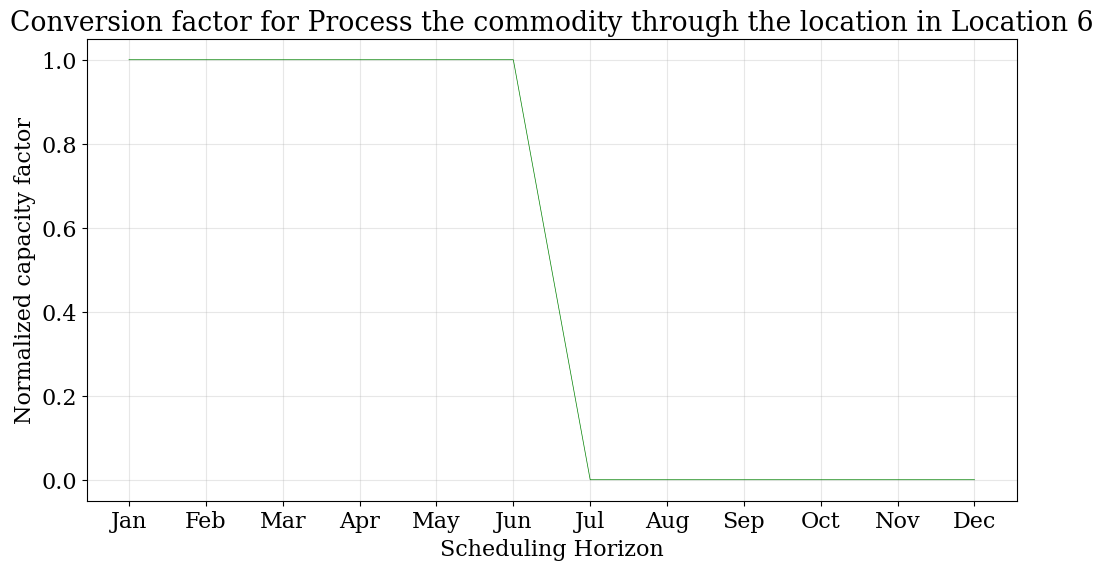

In [10]:
plot_scenario.capacity_factor(scenario=scenario, process=com1_process, location=loc6, color='green')

In [11]:
problem_mincost = formulate(scenario=scenario,
                            constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND, Constraints.MODE},
                            demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint production mode facility
constraint min production mode facility
constraint nameplate production mode
constraint production mode wo binary
constraint production rate1
constraint production rate2
constraint production mode switch
constraint demand penalty
objective cost w demand penalty


In [12]:
# problem_mincost.constraint_nameplate_production_mode['loc6','com1_process',0,0,7,0].pprint()

In [13]:
results_mincost = solve(scenario=scenario, instance=problem_mincost, solver='gurobi', name='MILP')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1100401 rows, 3043145 columns and 1634973 nonzeros
Model fingerprint: 0xdef8a085
Variable types: 2891063 continuous, 152082 integer (152082 binary)
Coefficient statistics:
  Matrix range     [6e-03, 1e+04]
  Objective range  [1e+00, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 1e+04]
Found heuristic solution: objective 1.800002e+13
Presolve removed 1059920 rows and 3006438 columns
Presolve time: 2.76s
Presolved: 40481 rows, 36707 columns, 158389 nonzeros
Variable types: 21587 continuous, 15120 integer (7560 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...
Concurrent spin time: 0.00s

Solved with dual simplex
Extra simplex iterations after uncrush: 10

Root relaxation: objective 2.120059e+12, 29903 ite

In [14]:
sum(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold') /(daily_demand*_time_intervals*_exec_scenarios)

KeyError: 'S'

In [ ]:
min(value for key, value in results_mincost.output['S'].items() if key[0] == 'loc5' and key[1] == 'com1_sold')

In [ ]:
plot_results.schedule(results=results_mincost, y_axis='S', component='com1_sold', location='loc5', color='green')

In [ ]:
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store2k_com1_in_stored', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store5k_com1_in_stored', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store4k_com1_in_stored', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store8k_com1_in_stored', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store8k_com1_in_stored', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store2k_com1_in_stored', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='Inv', component='com1_store5k_com1_in_stored', location='loc7', color='green')

In [ ]:
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc1', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc2', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc3', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc4', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc5', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc6', color='green')
plot_results.schedule(results=results_mincost, y_axis='P', component='com1_process', location='loc7', color='green')